# 🏪🛒**Rossmann Store Sales Time Series Problem**

## Import Library

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
! unzip /content/Data_store.zip

Archive:  /content/Data_store.zip
  inflating: Data_store/store.csv    
  inflating: Data_store/test.csv     
  inflating: Data_store/train.csv    


##  Load Dataset

In [ ]:
store_data=pd.read_csv('/content/Data_store/store.csv')
train_data = pd.read_csv("/content/Data_store/train.csv")
test_data=pd.read_csv('/content/Data_store/test.csv')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


Date column is object ,convert it into datetime

## Data Cleaning

#### convert date column into datetime data type && set it as index

In [ ]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['Date'].dtype

dtype('<M8[ns]')

In [ ]:
train_data = train_data.set_index(train_data['Date'])
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,,
2015-07-31,1,5,2015-07-31,5263,555,1,1,0,1
2015-07-31,2,5,2015-07-31,6064,625,1,1,0,1
2015-07-31,3,5,2015-07-31,8314,821,1,1,0,1
2015-07-31,4,5,2015-07-31,13995,1498,1,1,0,1
2015-07-31,5,5,2015-07-31,4822,559,1,1,0,1


### check another dataset

In [ ]:
test_data = test_data.set_index(test_data['Date'])
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-09-17,1,1,4,2015-09-17,1.0,1,0,0
2015-09-17,2,3,4,2015-09-17,1.0,1,0,0
2015-09-17,3,7,4,2015-09-17,1.0,1,0,0
2015-09-17,4,8,4,2015-09-17,1.0,1,0,0
2015-09-17,5,9,4,2015-09-17,1.0,1,0,0


In [ ]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
print(f'shape of train data: {train_data.shape}')
print(f'shape of test data: {test_data.shape}')
print(f'shape of store data: {store_data.shape}')

shape of train data: (1017209, 9)
shape of test data: (41088, 8)
shape of store data: (1115, 10)


#### check missing values

In [ ]:
train_data.isna().sum()

,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0


- **train data is clean**🧹

In [ ]:
test_data.isna().sum()

,0
Id,0
Store,0
DayOfWeek,0
Date,0
Open,11
Promo,0
StateHoliday,0
SchoolHoliday,0


- **there are some missing values on open column 11 value**

In [ ]:
test_data['Open'] = test_data['Open'].fillna(1)

In [ ]:
test_data.isna().sum()

,0
Id,0
Store,0
DayOfWeek,0
Date,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0


In [ ]:
store_data.isna().sum()

,0
Store,0
StoreType,0
Assortment,0
CompetitionDistance,3
CompetitionOpenSinceMonth,354
CompetitionOpenSinceYear,354
Promo2,0
Promo2SinceWeek,544
Promo2SinceYear,544
PromoInterval,544


- **there lot of missing in this dataframe columns[CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear,PromoInterval]**   

In [ ]:
store_data['CompetitionOpenSinceMonth'].unique()

array([ 9., 11., 12.,  4., 10.,  8., nan,  3.,  6.,  5.,  1.,  2.,  7.])

In [ ]:
store_data['CompetitionOpenSinceMonth']=store_data['CompetitionOpenSinceMonth'].fillna(store_data['CompetitionOpenSinceMonth'].median())

filling misssing in CompetitionOpenSinceMonth with median value  

In [ ]:
store_data['CompetitionOpenSinceYear'].unique()

array([2008., 2007., 2006., 2009., 2015., 2013., 2014., 2000., 2011.,
         nan, 2010., 2005., 1999., 2003., 2012., 2004., 2002., 1961.,
       1995., 2001., 1990., 1994., 1900., 1998.])

In [ ]:
store_data['CompetitionOpenSinceYear']= store_data['CompetitionOpenSinceYear'].fillna(0)

filling misssing in CompetitionOpenSinceYear with zero value  

#### check unique value in each column & fill missing values

In [ ]:
store_data['Promo2SinceWeek'].unique()

array([nan, 13., 14.,  1., 45., 40., 26., 22.,  5.,  6., 10., 31., 37.,
        9., 39., 27., 18., 35., 23., 48., 36., 50., 44., 49., 28.])

In [ ]:
store_data['Promo2SinceYear'].unique()

array([  nan, 2010., 2011., 2012., 2009., 2014., 2015., 2013.])

In [ ]:
store_data['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [ ]:
store_data['Promo2SinceWeek']=store_data['Promo2SinceWeek'].fillna(0)
store_data['Promo2SinceYear']=store_data['Promo2SinceYear'].fillna(0)
store_data['PromoInterval']=store_data['PromoInterval'].fillna('None')

In [ ]:
store_data.isna().sum()

,0
Store,0
StoreType,0
Assortment,0
CompetitionDistance,3
CompetitionOpenSinceMonth,0
CompetitionOpenSinceYear,0
Promo2,0
Promo2SinceWeek,0
Promo2SinceYear,0
PromoInterval,0


In [ ]:
# store_data['CompetitionDistance'].unique()

In [ ]:
store_data['CompetitionDistance']=store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].median())

In [ ]:
store_data.isna().sum()

,0
Store,0
StoreType,0
Assortment,0
CompetitionDistance,0
CompetitionOpenSinceMonth,0
CompetitionOpenSinceYear,0
Promo2,0
Promo2SinceWeek,0
Promo2SinceYear,0
PromoInterval,0


 **Now all values in store dataset are clean**

#### Store Similarity Insights and decide which store to choose

In [ ]:
store_data['StoreType'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

<Axes: xlabel='Date'>

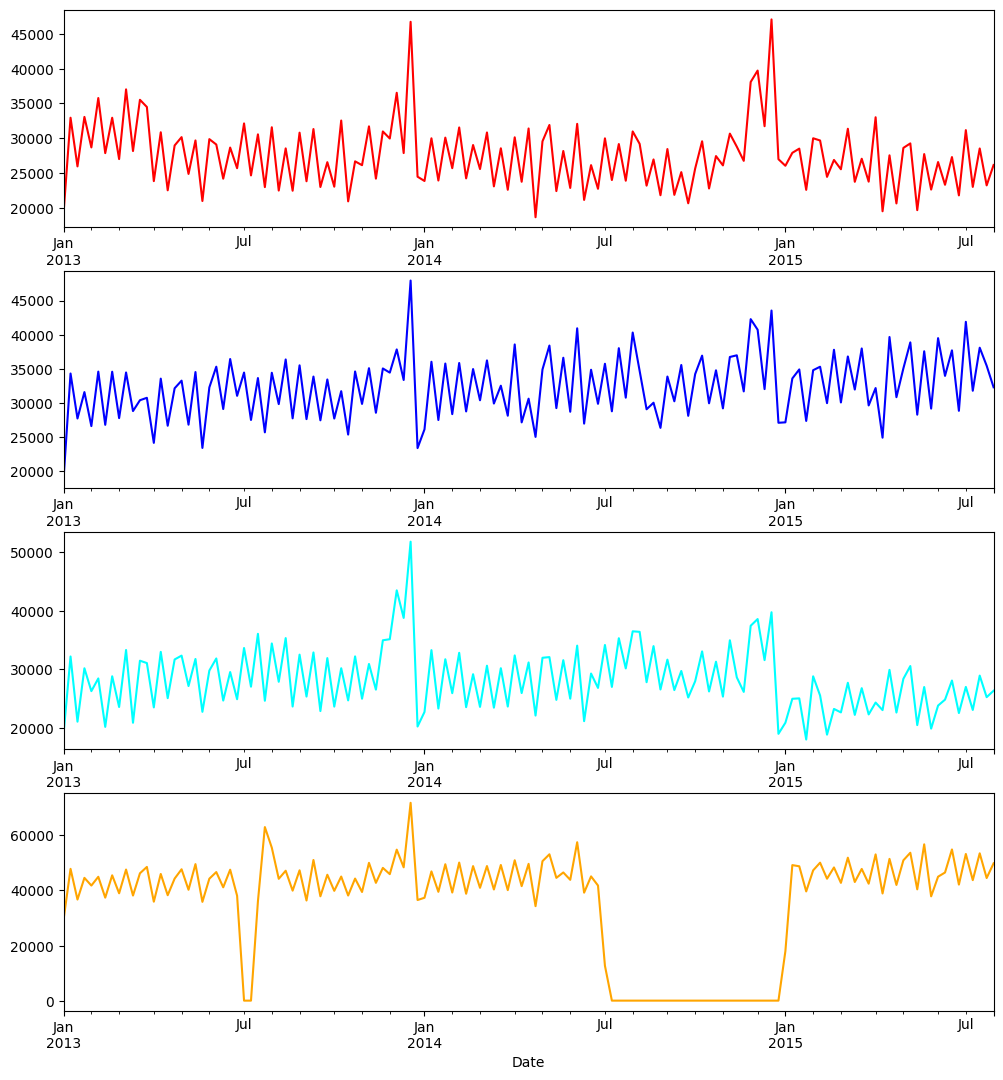

In [ ]:
train_data['Sales'] = train_data['Sales'].astype(float)

sales_a = train_data[train_data.Store == 1]['Sales']
sales_b = train_data[train_data.Store == 10]['Sales'].sort_index(ascending=True)
sales_c = train_data[train_data.Store == 40]['Sales']
sales_d = train_data[train_data.Store == 100]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 13))
sales_a.resample('W').sum().plot(color='red', ax=ax1)
sales_b.resample('W').sum().plot(color='blue', ax=ax2)
sales_c.resample('W').sum().plot(color='cyan', ax=ax3)
sales_d.resample('W').sum().plot(color='orange', ax=ax4)

we can see here the first following stores almost simaliar  and the store with further index is bad

### Now, choose one store forecasting

In [ ]:
store_id = 1

store_df = train_data[train_data['Store'] == store_id].copy()
store_df = store_df[store_df['Sales'] > 0]
if 'Date' in store_df.columns:
    store_df = store_df.drop(columns=['Date'])
store_df = store_df.sort_values('Date')

ts_store = store_df['Sales'].resample('D').sum().fillna(0)

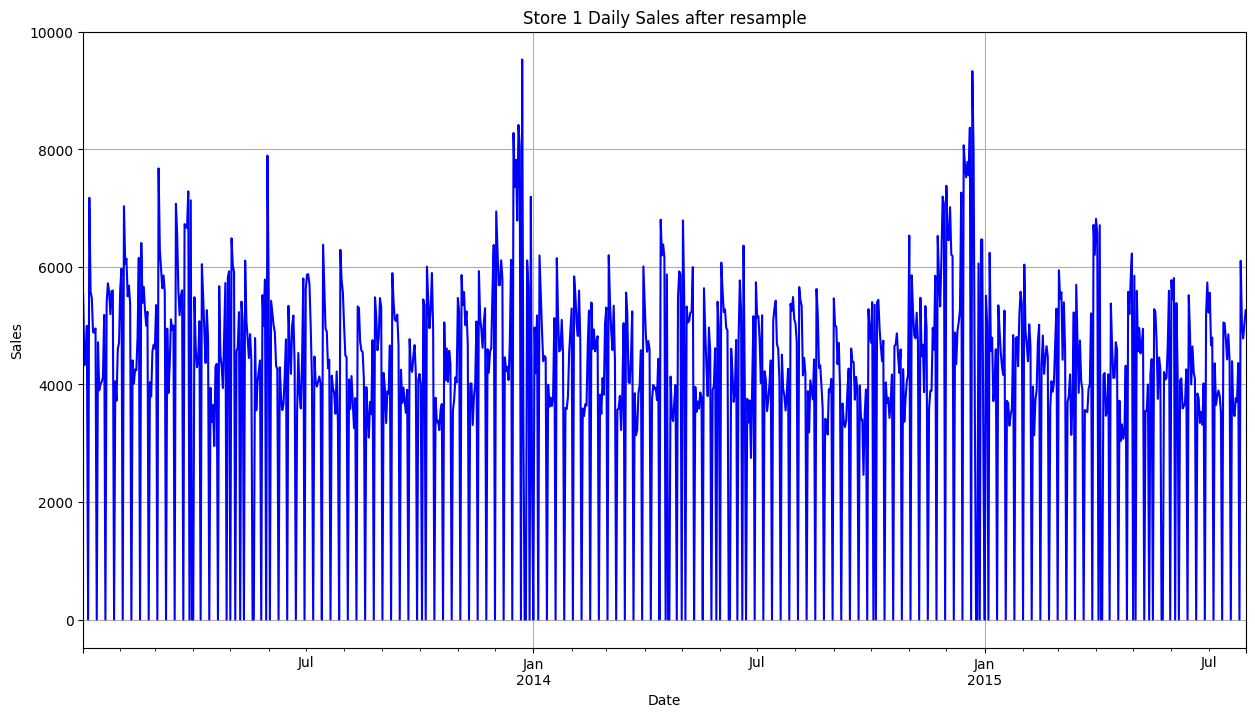

In [ ]:
plt.figure(figsize=(15, 8))
ts_store.plot(title=f'Store {store_id} Daily Sales after resample',color='blue')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid()
plt.show()

## Feature Engineering

In [ ]:
# data extraction
train_data['Year'] = train_data.index.year
train_data['Month'] = train_data.index.month
train_data['Day'] = train_data.index.day
train_data['WeekOfYear'] = train_data.index.isocalendar().week

In [ ]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
Date,,,,,,,,,,,,,
2015-07-31,1,5,2015-07-31,5263.0,555,1,1,0,1,2015,7,31,31
2015-07-31,2,5,2015-07-31,6064.0,625,1,1,0,1,2015,7,31,31
2015-07-31,3,5,2015-07-31,8314.0,821,1,1,0,1,2015,7,31,31
2015-07-31,4,5,2015-07-31,13995.0,1498,1,1,0,1,2015,7,31,31
2015-07-31,5,5,2015-07-31,4822.0,559,1,1,0,1,2015,7,31,31


 ## Exploratory Data Analysis

#### #colsed stores

Text(0.5, 1.0, 'show open & closed stores')

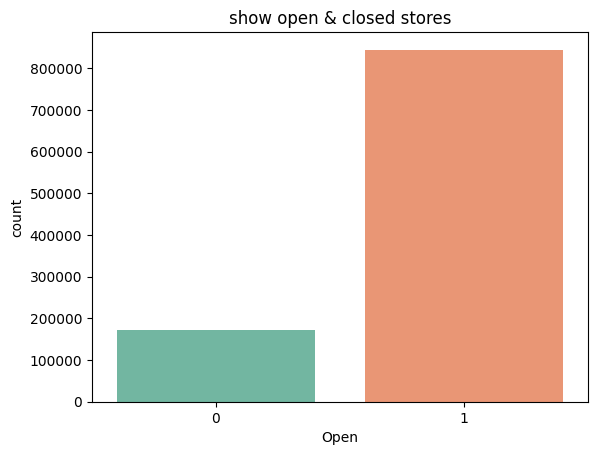

In [ ]:
sns.countplot(train_data, x="Open",palette='Set2')
plt.title("show open & closed stores")

In [ ]:
len(train_data[train_data['Open'] == 0])

172817

In [ ]:
len(train_data[(train_data["Open"] != 0) & (train_data['Sales'] != 0)])

844338

### merge store with train & test dataset


In [ ]:
train_merged = pd.merge(train_data, store_data, on='Store', how='left')
test_merged = pd.merge(test_data, store_data, on='Store', how='left')

In [ ]:
train_merged.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263.0,555,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
1,2,5,2015-07-31,6064.0,625,1,1,0,1,2015,...,31,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314.0,821,1,1,0,1,2015,...,31,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995.0,1498,1,1,0,1,2015,...,31,c,c,620.0,9.0,2009.0,0,0.0,0.0,None
4,5,5,2015-07-31,4822.0,559,1,1,0,1,2015,...,31,a,a,29910.0,4.0,2015.0,0,0.0,0.0,None


In [ ]:
train_merged.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

#### simple mean-based forecast

In [ ]:
test_data['Sales'] = 0
avg_sales = train_data[train_data['Open'] == 1].groupby('Store')['Sales'].mean()
test_data = pd.merge(test_data, avg_sales, on='Store', how='left')
test_data['Sales'] = test_data.apply(lambda row: row['Sales_y'] if row['Open'] == 1 else 0, axis=1)

test_data['Forecast'] = test_data['Sales']
test_data[['Id', 'Forecast']].head()


,Id,Forecast
0,1,4759.096031
1,2,6942.568678
2,3,8817.050891
3,4,5539.358418
4,5,6562.337612


#### Total Sales Over Time

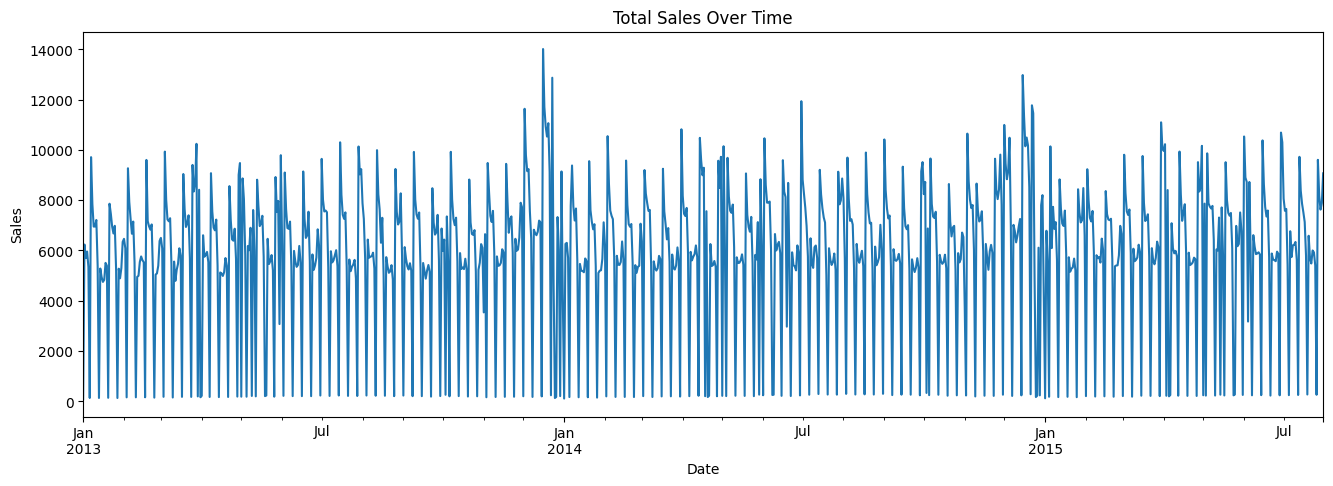

In [ ]:
plt.figure(figsize=(16, 5))
train_merged.groupby(train_merged['Date'])["Sales"].mean().plot()
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

## Naive Forecasting Baseline

In [ ]:
def rmspe(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    non_zero_mask = y_true != 0
    y_true = y_true[non_zero_mask]
    y_pred = y_pred[non_zero_mask]

    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2))


#### split data into train & valid for Naive

In [ ]:
train_data['Date'].max()

Timestamp('2015-07-31 00:00:00')

we choose 1 June before 30 day from the last day in this data

In [ ]:
split_date = '2015-06-01'

train_naive = train_data[train_data['Date'] < split_date].copy()
valid = train_data[train_data['Date'] >= split_date].copy()

In [ ]:
avg_sale = train_naive.groupby(['Store', 'DayOfWeek'])['Sales'].mean().reset_index()
avg_sale.rename(columns={'Sales': 'Sales_Forecast'}, inplace=True)
valid = valid.merge(avg_sale, on=['Store', 'DayOfWeek'], how='left')
valid = valid.dropna(subset=['Sales_Forecast'])

rmspe_naive = rmspe(valid['Sales'].values, valid['Sales_Forecast'].values)
print(f"Naive RMSPE: {rmspe_naive:.4f}")


Naive RMSPE: 0.2211


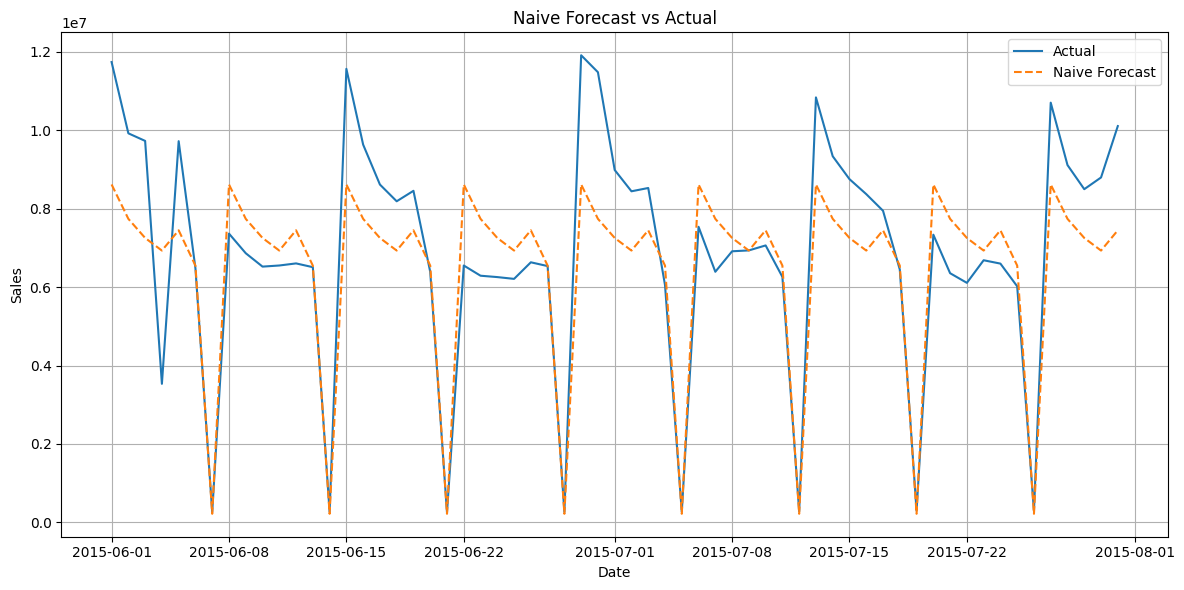

In [ ]:
daily_actual = valid.groupby('Date')['Sales'].sum()
daily_forecast = valid.groupby('Date')['Sales_Forecast'].sum()

plt.figure(figsize=(12, 6))
plt.plot(daily_actual.index, daily_actual.values, label='Actual')
plt.plot(daily_forecast.index, daily_forecast.values, label='Naive Forecast', linestyle='--')
plt.title('Naive Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## ETS Forecasting (Exponential Smoothing)

In [ ]:
def get_store_data(store_id, train_df, valid_df):
    store_train = train_df[train_df['Store'] == store_id].copy()
    store_valid = valid_df[valid_df['Store'] == store_id].copy()

    store_train = store_train[store_train['Sales'] > 0]
    store_valid = store_valid[store_valid['Sales'] > 0]

    store_train = store_train.set_index('Date')
    store_valid = store_valid.set_index('Date')


    return store_train, store_valid

store_id = 1
store_train, store_valid = get_store_data(store_id, train_merged, valid)


store_ts = store_train['Sales'].resample('D').sum().asfreq('D')
valid_ts = store_valid['Sales'].resample('D').sum().asfreq('D')


In [ ]:
ets_model = ExponentialSmoothing(store_ts,trend='add',seasonal='add',seasonal_periods=7,damped_trend=True).fit()

forecast_ets = ets_model.forecast(len(valid_ts))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
forecast_ets

,0
2015-08-01,5179.591667
2015-08-02,354.252348
2015-08-03,5136.226528
2015-08-04,4973.929148
2015-08-05,4756.370791
...,...
2015-09-26,5181.064877
2015-09-27,355.710826
2015-09-28,5137.670421
2015-09-29,4975.358602


#### evaluate & Plotting ETS

In [ ]:
rmspe_val = rmspe(valid_ts.values, forecast_ets.values)
print(f'ETS RMSPE on Store {store_id} validation: {rmspe_val:.4f}')

ETS RMSPE on Store 1 validation: 0.4363


#### visulaization of forecasting days for feature days

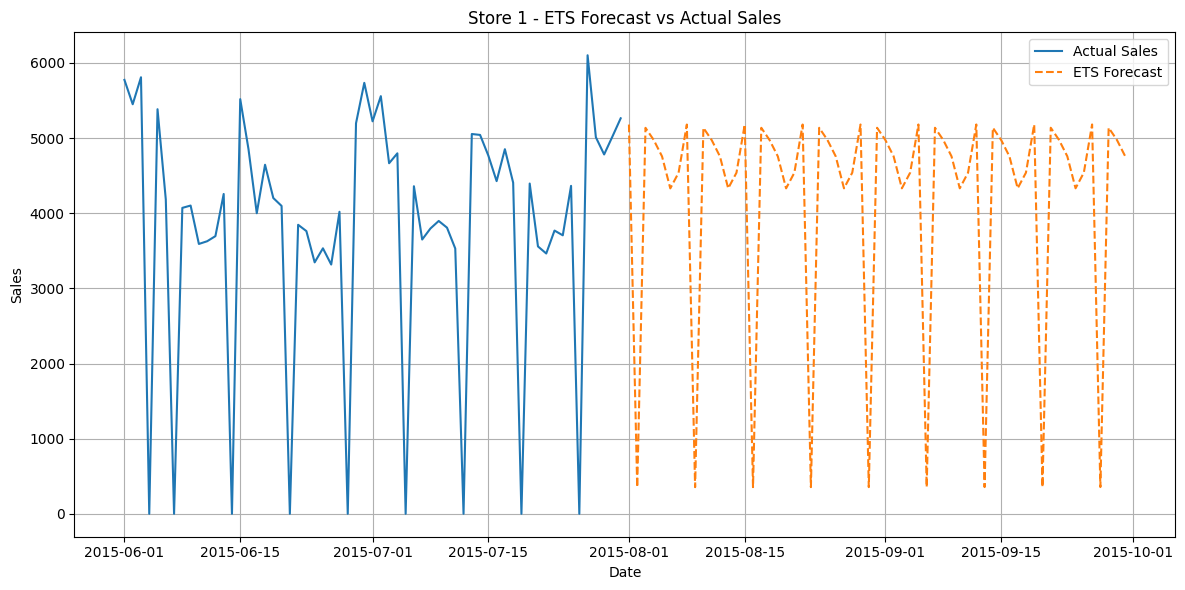

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(valid_ts.index, valid_ts.values, label='Actual Sales')
plt.plot(forecast_ets.index, forecast_ets.values, label='ETS Forecast', linestyle='--')
plt.title(f'Store {store_id} - ETS Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### visulaization for actual days & forecasting

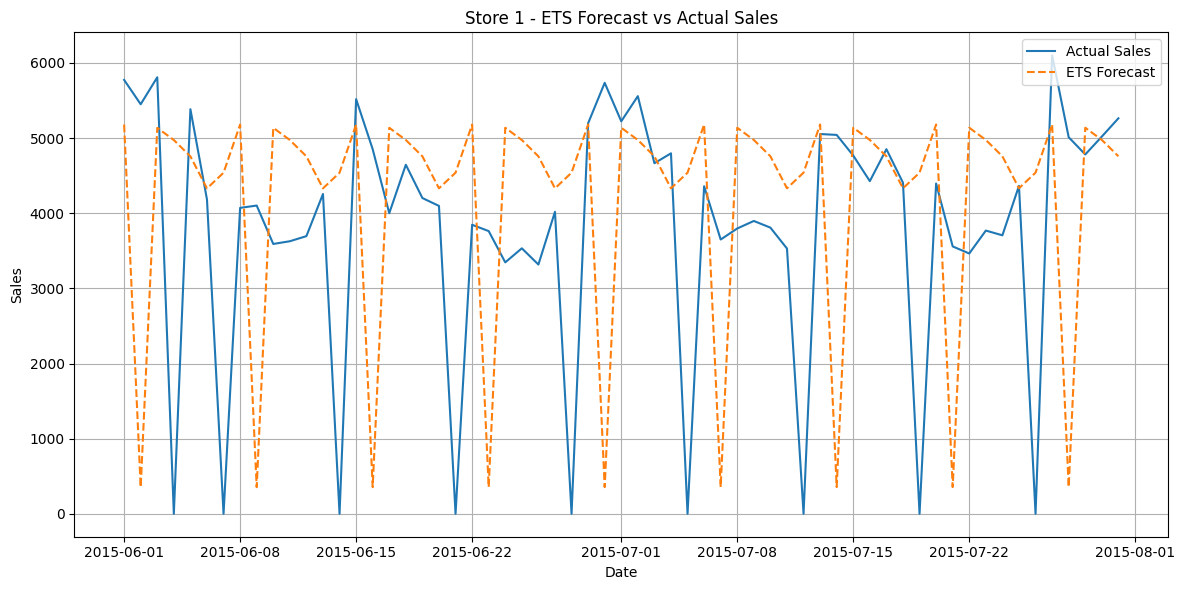

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(valid_ts.index, valid_ts.values, label='Actual Sales')
plt.plot(valid_ts.index, forecast_ets.values, label='ETS Forecast', linestyle='--')
plt.title(f'Store {store_id} - ETS Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### visualization ETS components

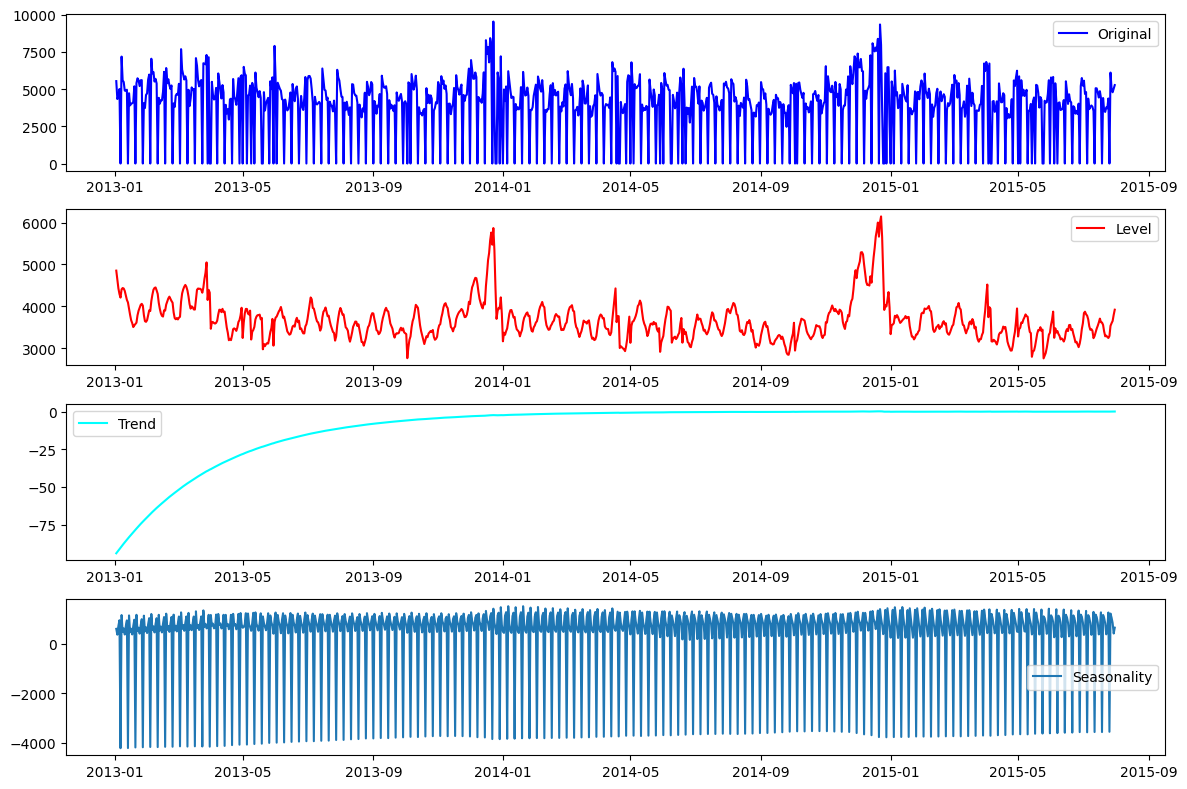

In [ ]:
fitted = ets_model.fittedvalues
level = ets_model.level
trend = ets_model.trend
season = ets_model.season

plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(store_ts, label='Original',color='blue')
plt.legend()

plt.subplot(4,1,2)
plt.plot(level, label='Level',color='red')
plt.legend()

plt.subplot(4,1,3)
plt.plot(trend, label='Trend',color='cyan')
plt.legend()

plt.subplot(4,1,4)
plt.plot(season, label='Seasonality')
plt.legend()

plt.tight_layout()
plt.show()


## ARIMA

In [ ]:
arima_model = ARIMA(store_ts, order=(1, 1, 1))
arima_result = arima_model.fit()

forecast_arima = arima_result.forecast(steps=len(valid_ts))


In [ ]:
rmspe_arima = rmspe(valid_ts.values, forecast_arima.values)
print(f'ARIMA RMSPE on Store {store_id} validation: {rmspe_arima:.4f}')

ARIMA RMSPE on Store 1 validation: 0.1734


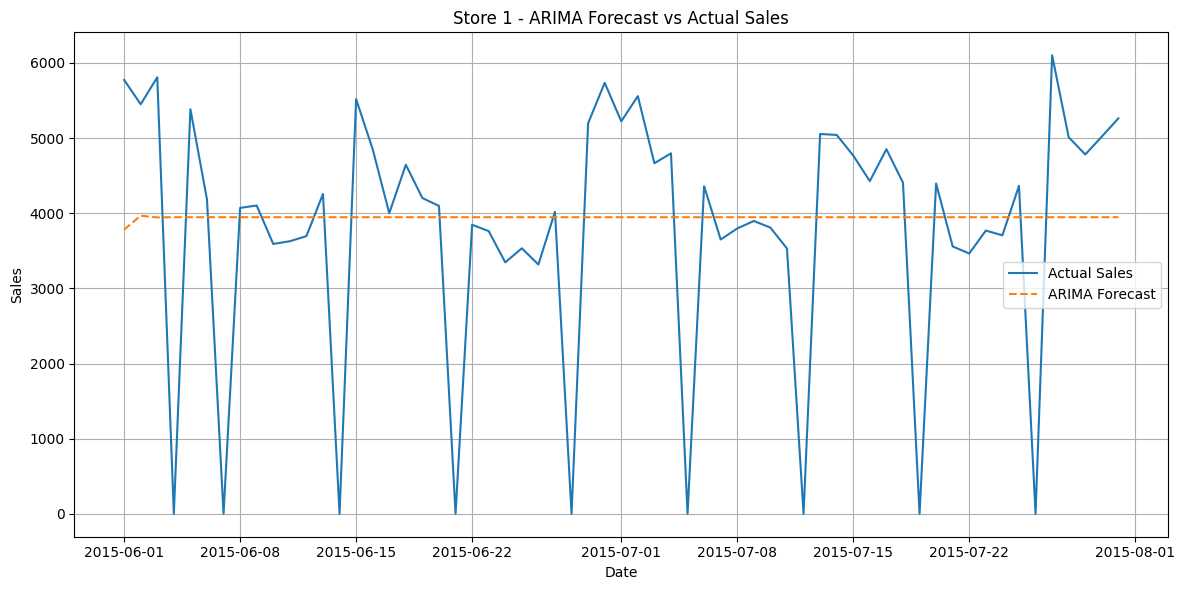

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(valid_ts.index, valid_ts.values, label='Actual Sales')
plt.plot(valid_ts.index, forecast_arima, label='ARIMA Forecast', linestyle='--')
plt.title(f'Store {store_id} - ARIMA Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Prophet

### Prepare data for prophet

In [ ]:
store_id = 1
store_train, store_valid = get_store_data(store_id, train_merged, valid)

prophet_train = store_train.groupby('Date')['Sales'].sum().reset_index()
prophet_train.columns = ['ds', 'y']

prophet_valid = store_valid.groupby('Date')['Sales'].sum().reset_index()
prophet_valid.columns = ['ds', 'y']


In [ ]:
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=True)
prophet_model.fit(prophet_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9_ngl2xg/ij7r7x73.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9_ngl2xg/v312j8gl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78134', 'data', 'file=/tmp/tmp9_ngl2xg/ij7r7x73.json', 'init=/tmp/tmp9_ngl2xg/v312j8gl.json', 'output', 'file=/tmp/tmp9_ngl2xg/prophet_model4jv570pn/prophet_model-20250530155928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:59:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:59:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
test_future = prophet_model.make_future_dataframe(periods=len(prophet_valid), freq='D')

forecast_prophet = prophet_model.predict(test_future)

# Extract forecasted values for validation period
forecast_values = forecast_prophet.set_index('ds')['yhat'][-len(prophet_valid):]


In [ ]:
forecast_values

,yhat
ds,
2015-08-01,4762.532940
2015-08-02,4622.097713
2015-08-03,4998.582668
2015-08-04,4505.199997
2015-08-05,4373.518500
2015-08-06,4272.137283
2015-08-07,4542.184610
2015-08-08,4759.245269
2015-08-09,4618.810042


In [ ]:
# Evaluate with RMSPE
rmspe_prophet = rmspe(prophet_valid['y'].values, forecast_values.values)
print("---------------------------------------------------------------------")
print(f'Prophet RMSPE for Store {store_id}: {rmspe_prophet:.4f}')


---------------------------------------------------------------------
Prophet RMSPE for Store 1: 0.1907


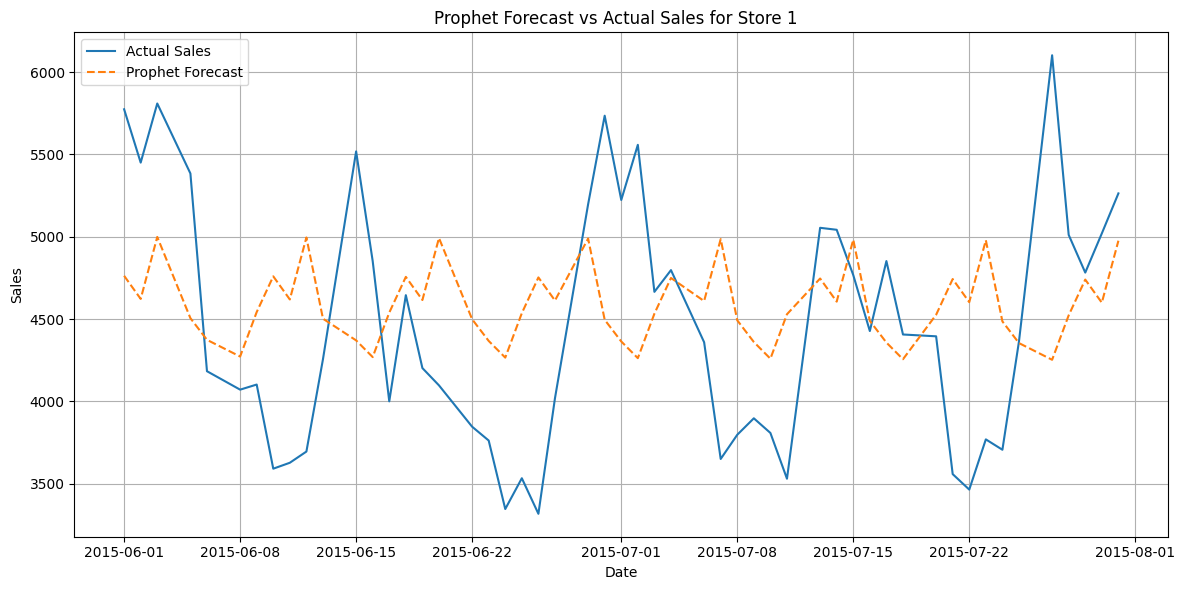

In [ ]:
# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(prophet_valid['ds'], prophet_valid['y'], label='Actual Sales')
plt.plot(prophet_valid['ds'], forecast_values, label='Prophet Forecast', linestyle='--')
plt.title(f'Prophet Forecast vs Actual Sales for Store {store_id}  ')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ML model

In [ ]:
train_merged.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263.0,555,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
1,2,5,2015-07-31,6064.0,625,1,1,0,1,2015,...,31,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314.0,821,1,1,0,1,2015,...,31,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995.0,1498,1,1,0,1,2015,...,31,c,c,620.0,9.0,2009.0,0,0.0,0.0,None
4,5,5,2015-07-31,4822.0,559,1,1,0,1,2015,...,31,a,a,29910.0,4.0,2015.0,0,0.0,0.0,None


In [ ]:
print(train_merged.columns)


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


##### Feature engineering

In [ ]:
# Feature engineering for train_merged
train_merged['Year'] = train_merged['Date'].dt.year
train_merged['Month'] = train_merged['Date'].dt.month
train_merged['Day'] = train_merged['Date'].dt.day
train_merged['WeekOfYear'] = train_merged['Date'].dt.isocalendar().week


##### Select one store

In [ ]:
# Select one store for modeling
store_id = 1
store_train = train_merged[train_merged['Store'] == store_id].copy()

# Remove closed days and zero sales to avoid noise
store_train = store_train[(store_train['Open'] == 1) & (store_train['Sales'] > 0)]

# Sort by date
store_train = store_train.sort_values('Date')

I use this date due to the last date in the data

### prepare data for ML model

##### working on categorical data

In [ ]:
# Train-validation split by date
split_date = '2015-06-01'
train_set = store_train[store_train['Date'] < split_date].copy()
valid_set = store_train[store_train['Date'] >= split_date].copy()


##### create features& encoding

In [ ]:
features = ['DayOfWeek', 'Promo', 'Year', 'Month', 'Day', 'WeekOfYear',
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear']

train_set['CompetitionDistance'] = train_set['CompetitionDistance'].fillna(train_set['CompetitionDistance'].median())
valid_set['CompetitionDistance'] = valid_set['CompetitionDistance'].fillna(train_set['CompetitionDistance'].median())


promo_cols = ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']
for col in promo_cols:
    train_set[col] = train_set[col].fillna(0)
    valid_set[col] = valid_set[col].fillna(0)

cat_cols = ['StoreType', 'Assortment', 'PromoInterval']
train_set = pd.get_dummies(train_set, columns=cat_cols)
valid_set = pd.get_dummies(valid_set, columns=cat_cols)

valid_set = valid_set.reindex(columns=train_set.columns, fill_value=0)

In [ ]:
X_train = train_set[features + [col for col in train_set.columns if col.startswith(('StoreType_', 'Assortment_', 'PromoInterval_'))]]
y_train = train_set['Sales']

X_valid = valid_set[features + [col for col in valid_set.columns if col.startswith(('StoreType_', 'Assortment_', 'PromoInterval_'))]]
y_valid = valid_set['Sales']


#### GradientBoostingRegressor

In [ ]:
gbr = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gbr.fit(X_train, y_train)

# Predict on validation set
y_pred = gbr.predict(X_valid)

# Evaluate with RMSPE
score = rmspe(y_valid, y_pred)
print(f"GradientBoostingRegressor RMSPE: {score:.4f}")


GradientBoostingRegressor RMSPE: 0.0950


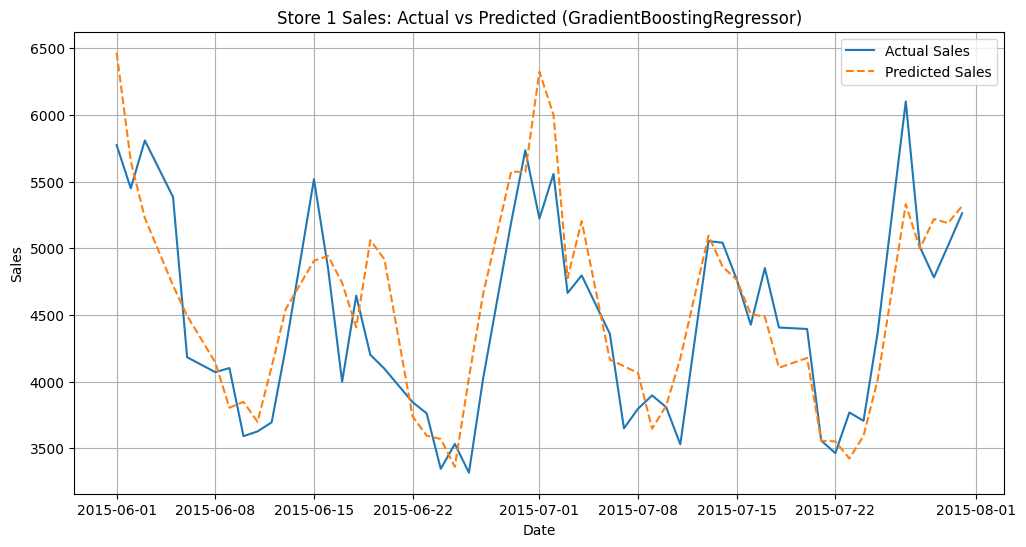

In [ ]:
# Plot actual vs predicted sales
plt.figure(figsize=(12,6))
plt.plot(valid_set['Date'], y_valid, label='Actual Sales')
plt.plot(valid_set['Date'], y_pred, label='Predicted Sales', linestyle='--')
plt.title(f'Store {store_id} Sales: Actual vs Predicted (GradientBoostingRegressor)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


#### another trail

In [ ]:
gbr2 = GradientBoostingRegressor(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gbr2.fit(X_train, y_train)

# Predict on validation set
y_pred2 = gbr2.predict(X_valid)

# Evaluate with RMSPE
score2 = rmspe(y_valid, y_pred2)
print(f"GradientBoostingRegressor RMSPE: {score2:.4f}")


GradientBoostingRegressor RMSPE: 0.0856


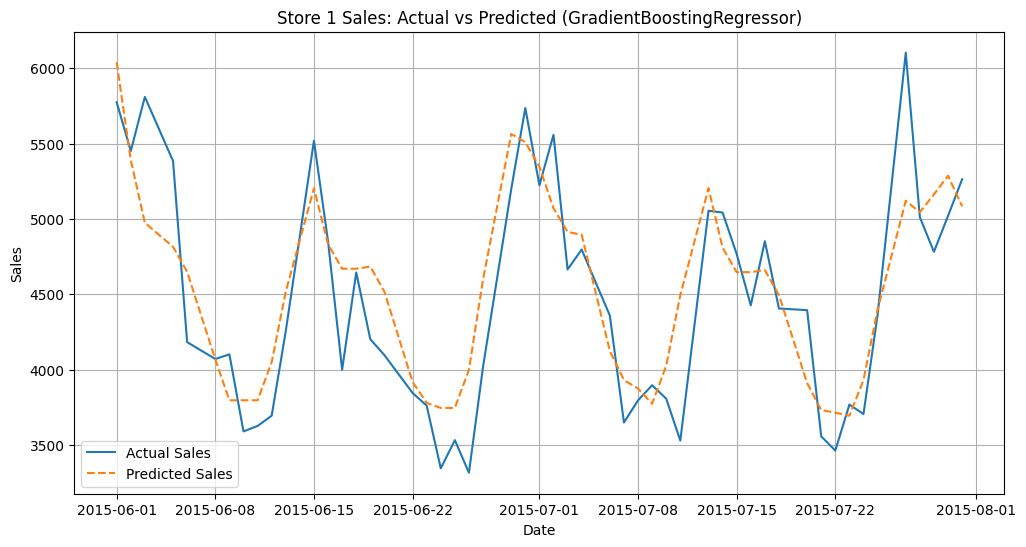

In [ ]:
# Plot actual vs predicted sales
plt.figure(figsize=(12,6))
plt.plot(valid_set['Date'], y_valid, label='Actual Sales')
plt.plot(valid_set['Date'], y_pred2, label='Predicted Sales', linestyle='--')
plt.title(f'Store {store_id} Sales: Actual vs Predicted (GradientBoostingRegressor)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


### create test data for kaggle submission

In [ ]:
test_merged['Date'] = pd.to_datetime(test_merged['Date'])

test_merged['Year'] = test_merged['Date'].dt.year
test_merged['Month'] = test_merged['Date'].dt.month
test_merged['Day'] = test_merged['Date'].dt.day
test_merged['WeekOfYear'] = test_merged['Date'].dt.isocalendar().week


test_merged['CompetitionDistance'] = test_merged['CompetitionDistance'].fillna(train_set['CompetitionDistance'].median())

promo_cols = ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']
for col in promo_cols:

    test_merged[col] = test_merged[col].fillna(0)

cat_cols = ['StoreType', 'Assortment', 'PromoInterval']

test_merged = pd.get_dummies(test_merged, columns=cat_cols)

test_merged = test_merged.reindex(columns=X_train.columns, fill_value=0)


X_test = test_merged[X_train.columns]

In [ ]:
test_data['Forecast'] = gbr2.predict(X_test)

submission = test_data[['Id']].copy()
submission['Sales'] = test_data['Forecast']

submission.to_csv('submission.csv', index=False)

### submission score

#### submission score : 0.39174